In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import os
from os import listdir
import imageio
import moviepy.editor as mpy

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [4]:
image_folder = './img_align_celeba_png/'
SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 5000
Z_DIM = 128
BZ = (BATCH_SIZE,Z_DIM)
BUF = 65536

W_EPOCH = 256

num_img = 0

LAMBDA = 10.0
alpha = 1e-4
beta_1 = 0.0
beta_2 = 0.9

In [5]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [6]:
class DatasetGenerator:

    def __init__(self):
        global num_img
        self.img_name = []
        for i, name in enumerate(listdir(image_folder)):
            num_img += 1
            self.img_name.append(name)

    def _data_preprocess(self, img_name):
        image_file = tf.io.read_file(image_folder + img_name)
        img = tf.io.decode_jpeg(image_file, channels=3)
        img = tf.image.resize(img, size=[IMG_H, IMG_W])
        img = tf.cast(img, tf.float32)
        img = img/255

        return img

    def generate(self):
        img_name = self.img_name
        dataset = tf.data.Dataset.from_tensor_slices((img_name))
        dataset = dataset.shuffle(BUF)
        dataset = dataset.map(self._data_preprocess, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        return dataset

In [7]:
num_img = 0
dataset = DatasetGenerator().generate()
print(dataset)
print("num of images: ", num_img)

<PrefetchDataset shapes: (100, 64, 64, 3), types: tf.float32>
num of images:  1001


In [8]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        # keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        # keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [9]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(learning_rate=alpha, beta_1=beta_1, beta_2=beta_2)
optimizer_d = keras.optimizers.Adam(learning_rate=alpha, beta_1=beta_1, beta_2=beta_2)

@tf.function
def WGTrain(c1):

    with tf.GradientTape() as tpd:

        z = tf.random.normal(BZ)
        eplison = tf.random.uniform(shape=(BATCH_SIZE,1,1,1), minval=0, maxval=1, dtype=tf.float32)
        c0 = WG(z, training = True)
        c2 = c1 * eplison + c0 * (1-eplison)

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)
        z2 = WD(c2)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)
        ## gradient penalty
        grad = tf.gradients(tf.reduce_mean(z2), c2)
        gradient_norm = tf.norm(grad, ord=2)
        ld = ld + (gradient_norm - 1)**2 * LAMBDA
    

    # apply gradients to critic
    gradient_g = tpd.gradient(lg, WG.trainable_variables)
    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1):

    with tf.GradientTape() as tpd:

        z = tf.random.normal(BZ)
        eplison = tf.random.uniform(shape=(BATCH_SIZE,1,1,1), minval=0, maxval=1, dtype=tf.float32)
        c0 = WG(z, training = True)
        c2 = c1 * eplison + c0 * (1-eplison)

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)
        z2 = WD(c2)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)
        ## gradient penalty
        grad = tf.gradients(tf.reduce_mean(z2), c2)
        gradient_norm = tf.norm(grad, ord=2)
        ld = ld + (gradient_norm - 1)**2 * LAMBDA
    

    # apply gradients to critic
    gradient_d = tpd.gradient(ld, WD.trainable_variables)
    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))
    
    return lg, ld

In [10]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

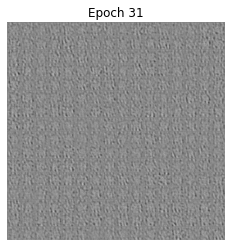

KeyboardInterrupt: 

In [12]:
wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(num_img)
ctr = 0
for ep in range(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dataset:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/w_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 32 == 0:
        
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [ ]:
utMakeGif(np.array(wsp), "imgs/wgan.gif", duration = 2)

In [ ]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()